In [30]:
import sys
import os
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import jax
import jax.numpy as jnp
import jax.random as jrandom
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import (
    create_triangular_lattice,
    is_equilateral_triangle,
    create_equilateral_triangular_lattice,
    aggr,
    compute_fuzzy_laplacian,
    propagate_features_fuzzy,
    generate_features_fuzzy,

    single_source_single_sink,
    solenoidal_vectorfield,

    generate_parameters,
    step
)

# Triangular lattice graph

## 1. Source sink potential

### 1.a Create potential

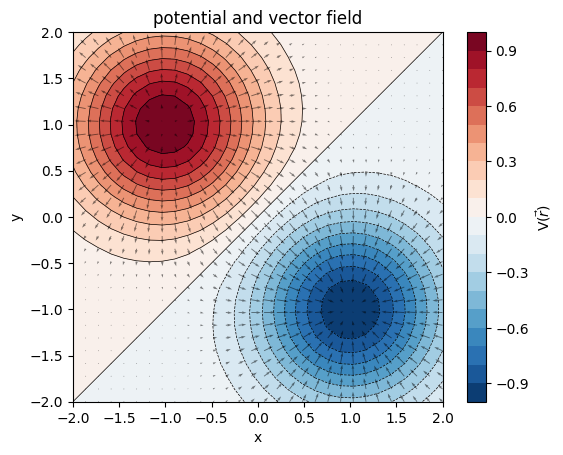

In [15]:
# Create a grid of points
n_pts = 30
x = jnp.linspace(-2, 2, n_pts)
y = jnp.linspace(-2, 2, n_pts)
X, Y = jnp.meshgrid(x, y)

R = np.zeros((n_pts**2, 2))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        R[(i*n_pts)+j] = jnp.array([X[i, j], Y[i, j]])
            
Z = np.zeros_like(X)

potential = single_source_single_sink
vector_field = np.zeros((n_pts, n_pts, 2))    

V, dVdx = jax.vmap(jax.value_and_grad(potential))(R)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        R[(i*n_pts)+j] = jnp.array([X[i, j], Y[i, j]])
        Z[i, j] = V[(i*n_pts)+j]
        vector_field[i, j] = -dVdx[(i*n_pts)+j]

plt.contour(X, Y, Z, levels=22, linewidths=0.5, colors='k')
plt.contourf(X, Y, Z, levels=22, cmap="RdBu_r")
plt.colorbar(label=r'V($\vec{r}$)', orientation='vertical')
plt.quiver(np.array(X), np.array(Y), np.array(vector_field[..., 0]), np.array(vector_field[..., 1]), alpha=0.5)
plt.title('potential and vector field')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 1.b Create triangular lattice graph

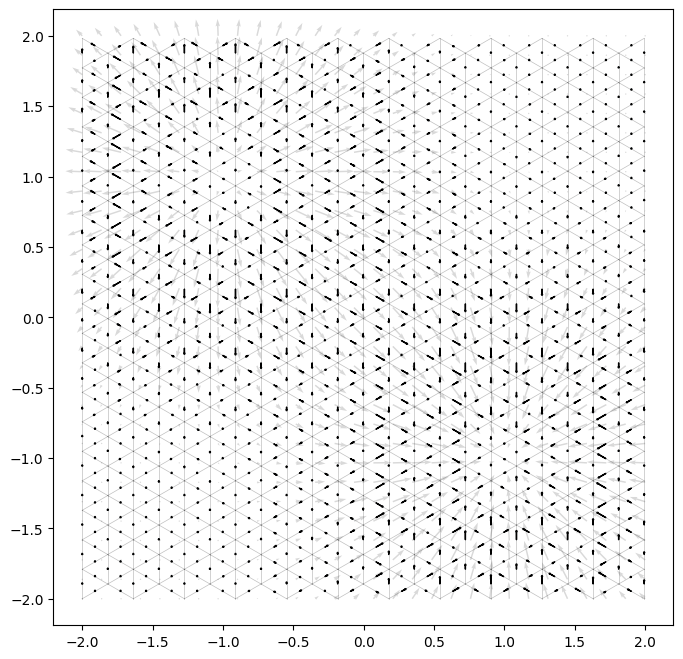

In [18]:
n_nodes_each_axis = 20
num_points = 800
lattice_width = 0.121 

triangular_lattice = create_triangular_lattice(num_points, lattice_width)
edges = create_equilateral_triangular_lattice(triangular_lattice)

r = triangular_lattice

R_index = cdist(r, R).argmin(axis=1)
r2R = {r: R for r, R in enumerate(R_index)}

count_boundary = 0
n_neighbors = 4

knn_graph = np.zeros((len(triangular_lattice), len(triangular_lattice)))
for i, j in edges:
    knn_graph[i, j] = 1
    knn_graph[j, i] = 1
receivers = [] 
senders = []
dVdij = []
vf_ij = []
for i in range(knn_graph.shape[0]):
    sender = np.nonzero(knn_graph[i])[0]
    receiver = [i for el in sender]
    receiver, sender = np.array(receiver), np.array(sender)
    edge_length = np.linalg.norm(r[receiver] - r[sender], axis=-1)
    receivers.extend(receiver)
    senders.extend(np.sort(sender))
    for src, tgt in zip(np.sort(sender), receiver):
        V_src = V[r2R[src]].item()
        V_tgt = V[r2R[tgt]].item()
        dVdij.append(V_tgt - V_src)

edge_index = np.array([receivers, senders])

conv_receivers = []
conv_senders = []
conv_dVdij = []
conv_projected_vf = []
conv_vf_ij = []

dVdij = np.array(dVdij)
dVdij -= dVdij.min()
dVdij /= dVdij.max()


for ind, (i, j) in enumerate(zip(*edge_index)):
    if i > j: continue
    conv_receivers.append(i)
    conv_senders.append(j)
    if use_gradient_force:
        conv_dVdij.append(dVdij[ind])
    else:
        conv_vf_ij.append(vf_ij[ind])

conv_theta = np.array(conv_dVdij) * np.pi/2

plt.figure(figsize=(8, 8))
for ind, (i, j) in enumerate(zip(conv_receivers, conv_senders)):
    xs = np.array([r[i, 0], r[j, 0]])
    ys = np.array([r[i, 1], r[j, 1]])
    move_ind = np.argmax([xs[1]-xs[0], ys[1]-ys[0]])
    mid_x, mid_y = xs.mean(), ys.mean()
    plt.plot(xs, ys, c='black', linewidth=0.5, alpha=0.25)
    director = conv_theta[ind] - np.pi/4
    edge_length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2)
    dr = 3*(edge_length / (np.pi/4)) * director
    if np.abs(dr) < 0.02:
        dr = 0
    dx = (xs[1]-mid_x)*dr
    dy = (ys[1]-mid_y)*dr
    plt.arrow(mid_x, mid_y, dx, dy, head_width=0.01, head_length=0.01, alpha=1)

plt.quiver(np.array(X), np.array(Y), np.array(vector_field[..., 0]), np.array(vector_field[..., 1]), alpha=0.15)
plt.axis('equal')
plt.show()

### 1.c Generate feature target ensemble

In [12]:
num_nodes = len(r)
num_instances = 500

num_features = 10

src_to_dst_kernel = jrandom.normal(jrandom.key(2), shape=(num_features, num_features))
dst_to_src_kernel = jrandom.normal(jrandom.key(3), shape=(num_features, num_features))
self_kernel = jrandom.normal(jrandom.key(4), shape=(num_features, num_features))
propagator = lambda feat: kernel_matrix @ feat

gaussian_features = jrandom.normal(jrandom.key(42), shape=(num_instances, num_nodes, num_features)) 
gaussian_features /= jnp.linalg.norm(gaussian_features, axis=-1, keepdims=True)

K = 11
edge_index_fuzzy = np.array([conv_receivers, conv_senders])
true_theta = conv_theta

edge_weight = None
add_self_loop = True
mix_self_with_dir = False
alpha = 0.5
use_nonlinearity = False

conv_kernels = (src_to_dst_kernel, dst_to_src_kernel, self_kernel)
fuzzy_hop_features = [
    generate_features_fuzzy(
        input_features, 
        edge_index_fuzzy, 
        true_theta, 
        num_nodes, 
        edge_weight, 
        add_self_loop, 
        mix_self_with_dir, 
        alpha, 
        K=K, 
        kernels=conv_kernels, 
        use_nonlinearity=use_nonlinearity)
    for input_features in gaussian_features
]

### 1.d Generate direction-informed positional encoding

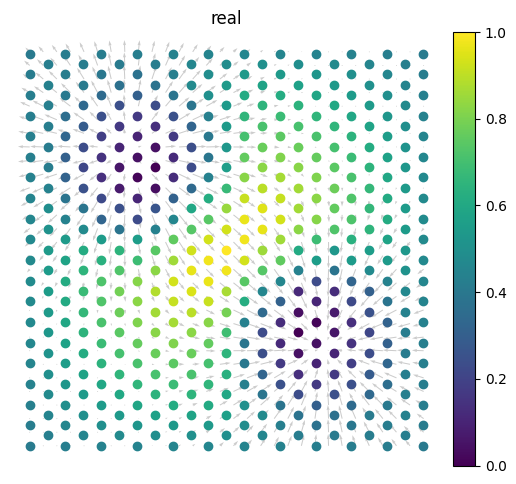

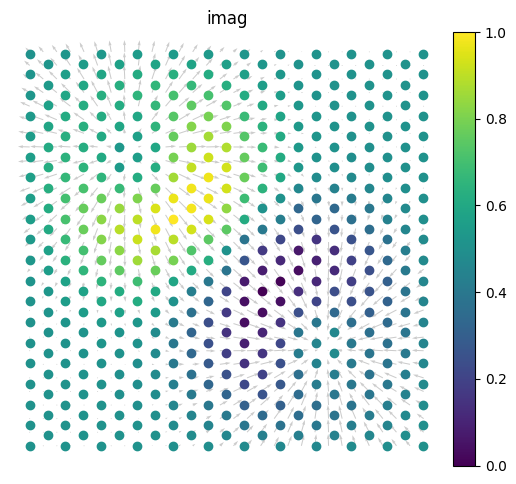

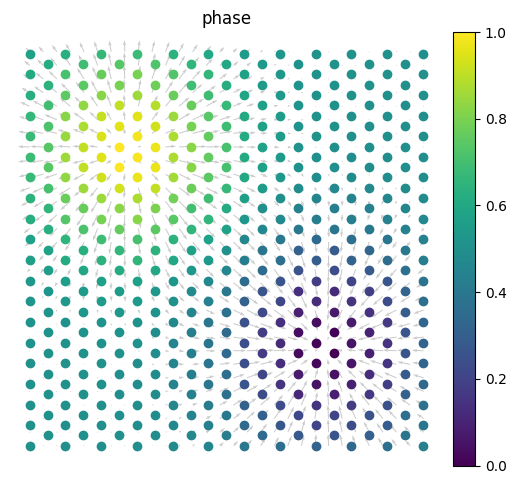

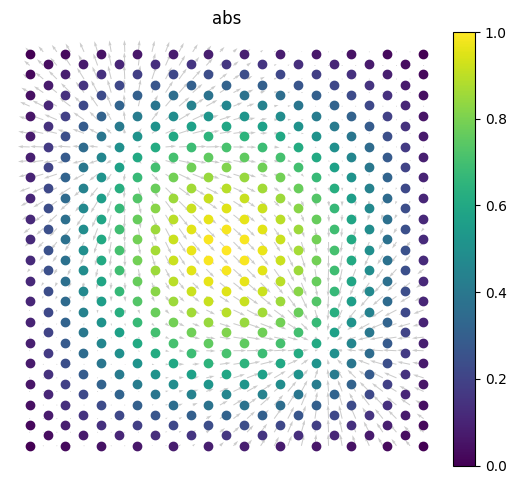

In [36]:
graph = np.zeros((len(triangular_lattice), len(triangular_lattice)))
for i, j in edges:
    graph[i, j] = 1
    graph[j, i] = 1

triu_edges = np.array(np.triu_indices(len(triangular_lattice))).T[graph[np.triu_indices(len(triangular_lattice))]==1]
tril_edges = np.array(np.tril_indices(len(triangular_lattice))).T[graph[np.tril_indices(len(triangular_lattice))]==1]
tril_edges_flip = np.copy(tril_edges)
tril_edges_flip[:, [0, 1]] = tril_edges_flip[:, [1, 0]]

triu_edges_set = set(tuple(el) for el in triu_edges)
tril_edges_set = set(tuple(el) for el in tril_edges)
tril_edges_flip_set = set(tuple(el) for el in tril_edges_flip) 

triu_symm_edges_set = triu_edges_set & tril_edges_flip_set
tril_symm_edges_set = set(el[::-1] for el in triu_symm_edges_set)

triu_dir_edges_set = triu_edges_set - triu_symm_edges_set
tril_dir_edges_set = tril_edges_set - tril_symm_edges_set

triu_dir_edges = sorted(list(triu_dir_edges_set))
tril_dir_edges = sorted(list(tril_dir_edges_set))
triu_symm_edges = sorted(list(triu_symm_edges_set))

edge2theta = {(i, j): th for j, i, th in zip(conv_senders, conv_receivers, conv_theta)}


for title, func in zip(['real', 'imag', 'phase', 'abs'], [np.real, np.imag, np.angle, np.abs]):
    L = np.zeros_like(graph)*1j
    for (i, j) in triu_symm_edges:
        L[i, j] = np.exp(1j*edge2theta[(i, j)])
    L += 1j * L.T.conj()
    
    eval, evec = np.linalg.eig(L)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('equal')
    
    evecs = func(evec[:, 0])
    evecs -= np.min(evecs)
    evecs /= np.max(evecs)
    colors = plt.cm.viridis(evecs)

    quiver = ax.quiver(
        np.array(X), 
        np.array(Y), 
        np.array(vector_field[..., 0]), 
        np.array(vector_field[..., 1]), 
        alpha=0.2)

    for i, point in enumerate(r):
        x, y = point
        x1, y1 = np.real(evec[i, 0]), np.imag(evec[i, 0])
        x2, y2 = np.real(evec[i, 1]), np.imag(evec[i, 1])
        x3, y3 = np.real(evec[i, 2]), np.imag(evec[i, 2])
        scatter = ax.scatter(x, y, color=colors[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.box(False)
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(scatter, cax=cax)
    plt.show()

## 2. Solenoid vector field

### 2.a Create vector field

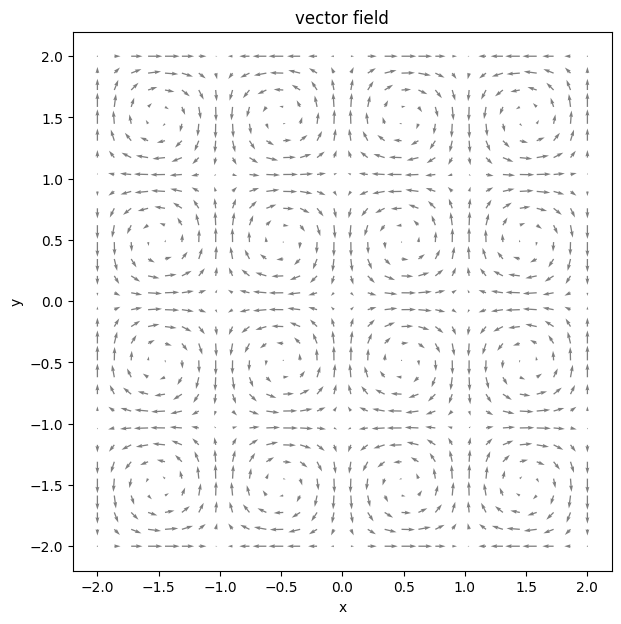

In [42]:
# Create a grid of points
n_pts = 30
x = jnp.linspace(-2, 2, n_pts)
y = jnp.linspace(-2, 2, n_pts)
X, Y = jnp.meshgrid(x, y)

R = np.zeros((n_pts**2, 2))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        R[(i*n_pts)+j] = jnp.array([X[i, j], Y[i, j]])

VF = np.zeros((n_pts**2, 2))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        VF[(i*n_pts)+j] = solenoidal_vectorfield((X[i, j], Y[i, j]))

plt.figure(figsize=(7, 7))
plt.quiver(np.array(X), np.array(Y), VF.reshape(n_pts, n_pts, 2)[..., 0], VF.reshape(n_pts, n_pts, 2)[..., 1], alpha=0.5)
plt.title('vector field')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 2.b Create triangular lattice graph

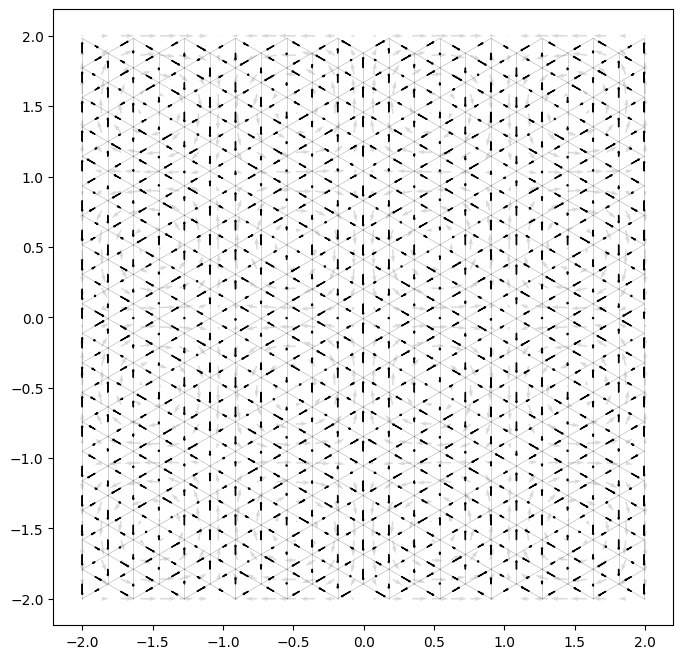

In [46]:
n_nodes_each_axis = 20
num_points = 800
lattice_width = 0.121 #0.12 # for example

triangular_lattice = create_triangular_lattice(num_points, lattice_width)
edges = create_equilateral_triangular_lattice(triangular_lattice)
r = triangular_lattice

R_index = cdist(r, R).argmin(axis=1)
r2R = {r: R for r, R in enumerate(R_index)}

count_boundary = 0
n_neighbors = 4
knn_graph = np.zeros((len(triangular_lattice), len(triangular_lattice)))
for i, j in edges:
    knn_graph[i, j] = 1
    knn_graph[j, i] = 1
receivers = [] 
senders = []
dVdij = []
vf_ij = []
for i in range(knn_graph.shape[0]):
    sender = np.nonzero(knn_graph[i])[0]
    receiver = [i for el in sender]
    receiver, sender = np.array(receiver), np.array(sender)
    edge_length = np.linalg.norm(r[receiver] - r[sender], axis=-1)
    receivers.extend(receiver)
    senders.extend(np.sort(sender))
    for src, tgt in zip(np.sort(sender), receiver):
        src_r, tgt_r = r[src], r[tgt]
        dR = np.array(tgt_r) - np.array(src_r)
        mid_point = np.array(src_r) + dR / 2
        dR /= np.linalg.norm(dR)
        vf_midpoint = solenoidal_vectorfield(mid_point)
        vf_midpoint /= np.linalg.norm(vf_midpoint)
        vf_ij.append(np.clip(np.arccos(dR @ vf_midpoint) / 2, 0, np.pi/2))

edge_index = np.array([receivers, senders])

conv_receivers = []
conv_senders = []
conv_dVdij = []
conv_projected_vf = []
conv_vf_ij = []

for ind, (i, j) in enumerate(zip(*edge_index)):
    if i > j: continue
    conv_receivers.append(i)
    conv_senders.append(j)
    conv_vf_ij.append(vf_ij[ind])

plt.figure(figsize=(8, 8))
for ind, (i, j) in enumerate(zip(conv_receivers, conv_senders)):
    xs = np.array([r[i, 0], r[j, 0]])
    ys = np.array([r[i, 1], r[j, 1]])
    move_ind = np.argmax([xs[1]-xs[0], ys[1]-ys[0]])
    mid_x, mid_y = xs.mean(), ys.mean()
    plt.plot(xs, ys, c='black', linewidth=0.5, alpha=0.25)
    director = conv_vf_ij[ind] - np.pi/4
    edge_length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2)
    dr = 3*(edge_length / (np.pi/4)) * director
    if np.abs(dr) < 0.02:
        dr = 0
    dx = (xs[1]-mid_x)*dr
    dy = (ys[1]-mid_y)*dr
    plt.arrow(mid_x, mid_y, dx, dy, head_width=0.01, head_length=0.01, alpha=1)


plt.quiver(np.array(X), np.array(Y), VF[:, 0], VF[:, 1], alpha=0.15)

plt.axis('equal')
plt.show()

### 2.c Generate direction-informed positional encoding

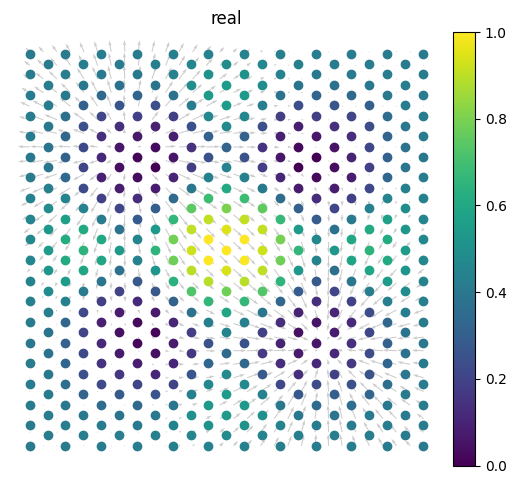

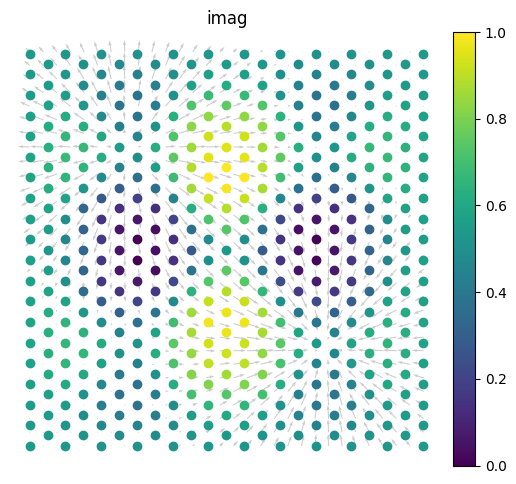

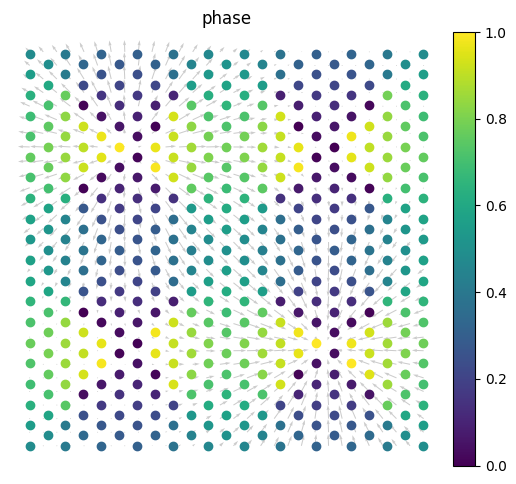

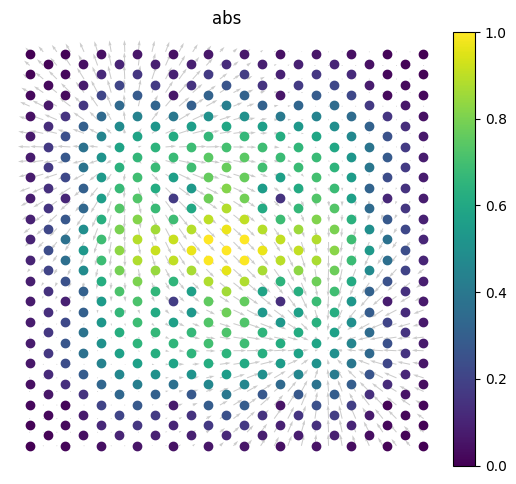

In [47]:
graph = np.zeros((len(triangular_lattice), len(triangular_lattice)))
for i, j in edges:
    graph[i, j] = 1
    graph[j, i] = 1

triu_edges = np.array(np.triu_indices(len(triangular_lattice))).T[graph[np.triu_indices(len(triangular_lattice))]==1]
tril_edges = np.array(np.tril_indices(len(triangular_lattice))).T[graph[np.tril_indices(len(triangular_lattice))]==1]
tril_edges_flip = np.copy(tril_edges)
tril_edges_flip[:, [0, 1]] = tril_edges_flip[:, [1, 0]]

triu_edges_set = set(tuple(el) for el in triu_edges)
tril_edges_set = set(tuple(el) for el in tril_edges)
tril_edges_flip_set = set(tuple(el) for el in tril_edges_flip) 

triu_symm_edges_set = triu_edges_set & tril_edges_flip_set
tril_symm_edges_set = set(el[::-1] for el in triu_symm_edges_set)

triu_dir_edges_set = triu_edges_set - triu_symm_edges_set
tril_dir_edges_set = tril_edges_set - tril_symm_edges_set

triu_dir_edges = sorted(list(triu_dir_edges_set))
tril_dir_edges = sorted(list(tril_dir_edges_set))
triu_symm_edges = sorted(list(triu_symm_edges_set))

edge2theta = {(i, j): th for j, i, th in zip(conv_senders, conv_receivers, conv_vf_ij)}


for title, func in zip(['real', 'imag', 'phase', 'abs'], [np.real, np.imag, np.angle, np.abs]):
    L = np.zeros_like(graph)*1j
    for (i, j) in triu_symm_edges:
        L[i, j] = np.exp(1j*edge2theta[(i, j)])
    L += 1j * L.T.conj()
    
    eval, evec = np.linalg.eig(L)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('equal')
    
    evecs = func(evec[:, 0])
    evecs -= np.min(evecs)
    evecs /= np.max(evecs)
    colors = plt.cm.viridis(evecs)

    quiver = ax.quiver(
        np.array(X), 
        np.array(Y), 
        np.array(vector_field[..., 0]), 
        np.array(vector_field[..., 1]), 
        alpha=0.2)

    for i, point in enumerate(r):
        x, y = point
        x1, y1 = np.real(evec[i, 0]), np.imag(evec[i, 0])
        x2, y2 = np.real(evec[i, 1]), np.imag(evec[i, 1])
        x3, y3 = np.real(evec[i, 2]), np.imag(evec[i, 2])
        scatter = ax.scatter(x, y, color=colors[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.box(False)
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(scatter, cax=cax)
    plt.show()

# Gene regulatory network

## 1. Obtain initial steady state

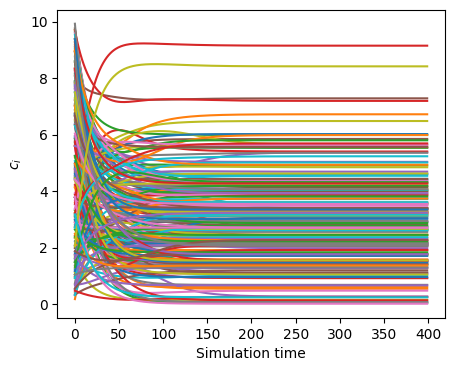

In [36]:
A, gamma_a, gamma_r, K = generate_parameters()

num_genes = len(A)

rng = np.random.default_rng(42)

n_steps = 400
inv_omega = 0 
dt = 0.05
n = 2
beta = 1

total_traj = []
c = rng.uniform(0.1, 10., size=num_genes)

rand_key = jrandom.key(42)

for i in range(n_steps):
    _key, rand_key = jrandom.split(rand_key)
    total_traj.append(c)
    c = step(c, dt, gamma_a, gamma_r, K, beta, inv_omega, _key, n)

steady_state = c

plt.figure(figsize=(5, 4))
plt.plot(np.array(total_traj))
plt.xlabel('Simulation time')
plt.ylabel(r'$c_i$')
plt.show()

## 2. Obtain new steady state following perturbation

Undo the break condition below to generate the full 200 single gene and 1000 double gene pertubations

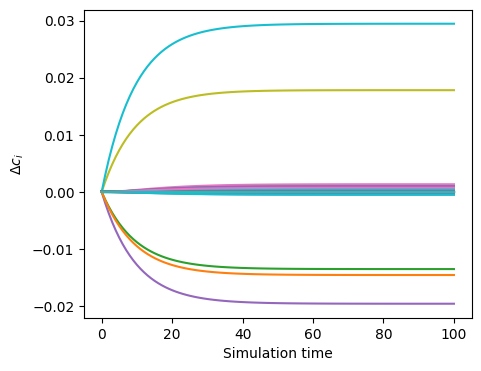

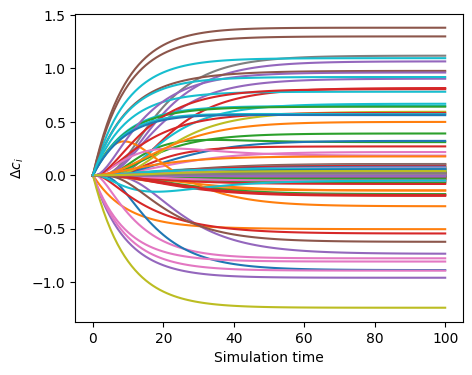

In [37]:
n_steps = 100
dt = 0.1
perturbation_value = 0.

rand_key = jrandom.key(42)

# single gene knockout
pert_data = {}
for num, gene_idx in enumerate(range(num_genes)):
    c = np.copy(steady_state)
    c[gene_idx] = perturbation_value    
    
    _traj = [c]
    for i in range(n_steps):
        _key, rand_key = jrandom.split(rand_key)
        c = step(c, dt, gamma_a, gamma_r, K, beta, inv_omega, _key, n)
        c = c.at[gene_idx].set(perturbation_value)
        _traj.append(c)
    pert_data[(gene_idx,)] = np.array(_traj[-1])   

    if num % 5 == 0:
        plt.figure(figsize=(5, 4))
        subtract = np.copy(steady_state)
        subtract[gene_idx] = 0.
        plt.plot(np.array(_traj) - subtract)
        plt.xlabel('Simulation time')
        plt.ylabel(r'$\Delta c_i$')
        plt.show() 
    if num > 2: break

# double gene knockout
num_samples = 1000
double_indices = rng.choice(
    list(combinations(range(num_genes), 2)), 
    size=(num_samples,), 
    replace=False)

for num, (gene_idx_1, gene_idx_2) in enumerate(double_indices):
    c = np.copy(steady_state)
    c[np.array([gene_idx_1, gene_idx_2])] = perturbation_value  

    _traj = [c]
    for i in range(n_steps):
        _key, rand_key = jrandom.split(rand_key, 2)
        c = step(c, dt, gamma_a, gamma_r, K, beta, inv_omega, _key, n)
        c = c.at[np.array([gene_idx_1, gene_idx_2])].set(perturbation_value)
        _traj.append(c)
    pert_data[(gene_idx_1, gene_idx_2)] = np.array(_traj[-1])

    if num % 5 == 0:
        plt.figure(figsize=(5, 4))
        subtract = np.copy(steady_state)
        subtract[np.array([gene_idx_1, gene_idx_2])] = 0.
        plt.plot(np.array(_traj) - subtract)
        plt.xlabel('Simulation time')
        plt.ylabel(r'$\Delta c_i$')
        plt.show() 
    if num > 2: break